In [1]:
%load_ext autoreload
%autoreload 2

# Final Evaluation

In [91]:
import os
import sys
import json
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Load data

In [92]:
# ## here I'm loading predictions from pickled predictions 
preds_path = '../data/predictions/predictions-final.pickle'
with open(preds_path, 'rb') as pickle_file:
    preds = pickle.load(pickle_file)

In [93]:
## load ground truths (val_gt.json)
with open('../data/predictions/val_gt.json') as json_file:
    val_gt = json.load(json_file)

In [94]:
## extract image ids
img_ids = {}
for vgt in val_gt['images']:
    img_ids[vgt['im_name']] = vgt['id']

### fix the dictionary
```python
cutoff = 1000
anno_dict2 = {}
for img in list(anno_dict.keys()):
    bboxes = anno_dict[img]

    bboxes2 = []
    for bbox in bboxes:
        if np.prod(bbox[2:]) > cutoff:
            bboxes2.append(bbox)
    if len(bboxes2) > 0:
        anno_dict2[img] = bboxes2
        
## get_annons
bboxes = []
for bb in anno_train[0, i][0][0][2]:
    if bb[0] > 0: # class_label = 1 means it is a person
        bboxes.append(bb[1:5]) # bbox format = [x, y, w, h]

## keep only images with persons
if bboxes != []:
    d[img_name] = bboxes        
```

In [95]:
val_gt['annotations'][0]

{'id': 1,
 'image_id': 1,
 'category_id': 1,
 'iscrowd': 0,
 'ignore': 0,
 'bbox': [947, 406, 17, 40],
 'vis_bbox': [950, 407, 14, 39],
 'height': 40,
 'vis_ratio': 0.802941176471}

In [96]:
## intersect with our predictions (441 images)
val_imgs = val_gt['images']
val_imgs = [val_img['im_name'] for val_img in val_imgs]

pred_imgs = list(preds.keys())
imgs = list(set(val_imgs) & set(pred_imgs))
len(imgs)

418

In [247]:
## subset val_gt and create test_gt
cutoff = 100
test_gt = {}
test_gt['categories'] = val_gt['categories']
test_gt['images'] = []
test_gt['annotations'] = []

for img in val_gt['images']:
    if img['im_name'] in imgs:
        test_gt['images'].append(img)

test_ids = []
for img in imgs:
    if img in list(img_ids.keys()):
        test_ids.append(img_ids[img])
        
for anno in val_gt['annotations']:
    if anno['image_id'] in test_ids:
        
        ## add area to anno (needed for default pycocotools eval)
        bbox = anno['bbox']
        area = int(bbox[2]) * int(bbox[3])
        anno['area'] = area
        
        ## cutoff small boxes
        if area > cutoff and anno['category_id'] > 0:
            test_gt['annotations'].append(anno)

In [248]:
## check
test_imgs = test_gt['images']
test_imgs = [test_img['im_name'] for test_img in test_imgs]
test_imgs[:5], len(test_imgs)

(['frankfurt_000000_000294_leftImg8bit.png',
  'frankfurt_000000_000576_leftImg8bit.png',
  'frankfurt_000000_001016_leftImg8bit.png',
  'frankfurt_000000_001236_leftImg8bit.png',
  'frankfurt_000000_001751_leftImg8bit.png'],
 418)

In [249]:
test_gt['images'][0]

{'id': 1,
 'im_name': 'frankfurt_000000_000294_leftImg8bit.png',
 'height': 1024,
 'width': 2048}

In [250]:
## GT bboxes
img_name = 'munster_000000_000019_leftImg8bit.png'
idx = test_imgs.index(img_name)
test1_img = test_gt['images'][idx]
img_name = test1_img['im_name']
img_id = test1_img['id']

bboxes = []
for anno in test_gt['annotations']:
    if anno['image_id'] == img_id and anno['category_id'] >= 1:
        bboxes.append(anno['bbox'])

In [251]:
# DT bboxes
bboxes_dt = np.round(preds[img_name]['boxes'])
bboxes_dt = bboxes_dt.tolist()

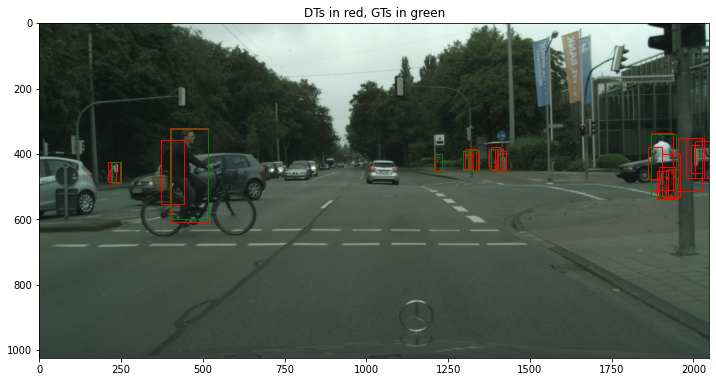

In [252]:
img = Image.open('../data/predictions/' + img_name)
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img);

for bbox in bboxes_dt:
    x1, y1, x2, y2 = bbox
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle(
        (x1, y1), w, h,
        linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.title('DTs in red, GTs in green')
plt.show()

In [253]:
## we can save the test_gt as json
with open('../data/predictions/test_gt.json', 'w', encoding='utf-8') as json_file:
    json.dump(test_gt, json_file, ensure_ascii=False, indent=4)

In [254]:
## see loadRes() and loadNumpyAnnotations() from COCO Class
## we need to provide [imageID, x1, y1, w, h, score, class] for each bbox:
test_dt = []
for img in imgs:
    bboxes = preds[img]['boxes']
    scores = preds[img]['scores']
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        w, h = x2 - x1, y2 - y1
        data = [img_ids[img], x1, y1, w, h, scores[i], 1]
        test_dt.append(data)
test_dt = np.array(test_dt)

In [255]:
## check
np.round(test_dt[0])

array([3.060e+02, 1.416e+03, 3.520e+02, 9.100e+01, 2.180e+02, 1.000e+00,
       1.000e+00])

In [256]:
## check
# should be a lot more detections than gt bboxes 
len(test_dt), len(test_gt['annotations'])

(14773, 3601)

In [257]:
print('About %.2f times more detected bboxes than there are gt bboxes' 
      % (len(test_dt) / len(test_gt['annotations'])))

About 4.10 times more detected bboxes than there are gt bboxes


# DEBUG

What I did:

* Converted CityPersons scripts in `eval_script` from Python2 to Python3 using `2to3 . -w .` in `./eval_script`
* I compared the code and why did you divide `gt['vis_ratio']` by 100?

# Evaluate

In [258]:
## Citypersons average miss rate measures
module_path = os.path.abspath(os.path.join('../src/eval_script/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from coco import COCO
from eval_MR_multisetup import COCOeval

annType = 'bbox'
annFile = '../data/predictions/test_gt.json'
resFile = test_dt

res_file_path = '../data/predictions/results.txt'
res_file = open(res_file_path, 'w')

for id_setup in range(0, 4):
    cocoGt = COCO(annFile)
    cocoDt = cocoGt.loadRes(resFile)
    imgIds = sorted(cocoGt.getImgIds())
    cocoEval = COCOeval(cocoGt, cocoDt, annType)
    cocoEval.params.imgIds = imgIds
    cocoEval.evaluate(id_setup)
    cocoEval.accumulate()
    cocoEval.summarize(id_setup, res_file)

res_file.close()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(14773, 7)
0/14773
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Miss Rate  (MR) @ Reasonable         [ IoU=0.50      | height=[50:10000000000] | visibility=[0.65:10000000000.00] ] = 25.33%
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(14773, 7)
0/14773
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.65s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Miss Rate  (MR) @ Reasonable_small   [ IoU=0.50      | height=[50:75] | visibility=[0.65:10000000000.00] ] = 50.96%
loading annotations into memory...
Done (t=0.01s)
c

In [259]:
## making the printout nicer..
print('Results: ')
res_file = open(res_file_path,'r')
lines = res_file.readlines()
res_file.close()
lines = [line.replace('10000000000.00', 'inf') for line in lines]
lines = [line.replace('10000000000', 'inf') for line in lines]
lines = [line.strip() for line in lines]
for line in lines:
    new = ''
    for elt in line.split(' '):
        if elt:
            new += elt + ' '
    print(new)

Results: 
Average Miss Rate (MR) @ Reasonable [ IoU=0.50 | height=[50:inf] | visibility=[0.65:inf] ] = 25.33% 
Average Miss Rate (MR) @ Reasonable_small [ IoU=0.50 | height=[50:75] | visibility=[0.65:inf] ] = 50.96% 
Average Miss Rate (MR) @ Reasonable_occ=heavy [ IoU=0.50 | height=[50:inf] | visibility=[0.20:0.65] ] = 63.56% 
Average Miss Rate (MR) @ All [ IoU=0.50 | height=[20:inf] | visibility=[0.20:inf] ] = 41.96% 


In [260]:
## rewrite as a row to add it to the benchmark table
results = [line.split('=')[-1] for line in lines]
results = [line.split('=')[-1] for line in lines]
results.insert(0, ' × ')
results.insert(0, ' Our FasterRCNN ')
results = [('**' + result.strip() + '**') for result in results]
results = ' | '.join(results)
results = ' | ' + results + ' | '
results

' | **Our FasterRCNN** | **×** | **25.33%** | **50.96%** | **63.56%** | **41.96%** | '

### Benchmark ###

|         Method         | External   training data | MR (Reasonable) | MR (Reasonable_small) | MR (Reasonable_occ=heavy) | MR (All) |
|:----------------------:|:----------------------:|:---------------:|:---------------------:|:-------------------------:|:--------:|
| [APD-pretrain](https://arxiv.org/abs/1910.09188) |  √ |      7.31%     |         10.81%        |           28.07%          |  32.71%  |
| [Pedestron](https://arxiv.org/abs/2003.08799) |  √ |      7.69%     |         9.16%        |           27.08%          |  28.33%  |
| [APD](https://arxiv.org/abs/1910.09188) |  ×  |      8.27%     |         11.03%        |           35.45%          |  35.65%  |
| YT-PedDet |  ×  |      8.41%     |         10.60%        |           37.88%          |  37.22%  |
| STNet |  ×  |      8.92%     |         11.13%        |           34.31%          |  29.54%  |
| [MGAN](https://arxiv.org/abs/1910.06160) |  ×  |      9.29%     |         11.38%        |           40.97%          |  38.86%  |
| DVRNet |  ×  |      11.17%     |         15.62%        |           42.52%          |  40.99%  |
| [HBA-RCNN](https://arxiv.org/abs/1911.11985) |  ×  |      11.26%     |         15.68%        |           39.54%          |  38.77%  |
| [OR-CNN](https://arxiv.org/abs/1807.08407)     |  ×  |      11.32%     |         14.19%        |           51.43%          |  40.19%  |
| [AdaptiveNMS](http://openaccess.thecvf.com/content_CVPR_2019/papers/Liu_Adaptive_NMS_Refining_Pedestrian_Detection_in_a_Crowd_CVPR_2019_paper.pdf)     |  ×  |      11.40%     |         13.64%        |           46.99%          |  38.89%  |
| [Repultion Loss](http://arxiv.org/abs/1711.07752)     |  ×  |      11.48%     |         15.67%        |           52.59%          |  39.17%  |
| [Cascade MS-CNN](https://arxiv.org/abs/1906.09756)     |  ×  |      11.62%     |         13.64%        |           47.14%          |  37.63%  |
| [Adapted FasterRCNN](http://202.119.95.70/cache/12/03/openaccess.thecvf.com/f36bf52f1783160552c75ae3cd300e84/Zhang_CityPersons_A_Diverse_CVPR_2017_paper.pdf)  |  ×  |      12.97%     |         37.24%        |           50.47%          |  43.86%  |
| [MS-CNN](https://arxiv.org/abs/1607.07155)     |  ×  |      13.32%     |         15.86%        |           51.88%          |  39.94%  |
| **Our FasterRCNN** | **×** | **24.73%** | **47.35%** | **64.74%** | **52.72%** | 

In [261]:
## Test using default pycocotools measures
module_path = os.path.abspath(os.path.join('../src/pycocotools/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from coco import COCO
from cocoeval import COCOeval

annType = 'bbox'
annFile = '../data/predictions/test_gt.json'
resFile = test_dt

cocoGt=COCO(annFile)
cocoDt = cocoGt.loadRes(resFile)

imgIds = sorted(cocoGt.getImgIds())
cocoEval = COCOeval(cocoGt, cocoDt, annType)

cocoEval.params.imgIds = imgIds
cocoEval.evaluate()

cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(14773, 7)
0/14773
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.97s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall

## TODOs:

1. Why did we get worst results here compared to results on the cloud. Using `evaluate(model, data_loader_test, device=device)` when testing on the same set:

Update:
```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
```